In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(3)*train_x**int(2) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[-8.0972e+00,  1.1881e+01],
        [-7.1415e+00,  1.1225e+01],
        [-6.1580e+00,  1.0155e+01],
        [-5.3789e+00,  9.3273e+00],
        [-4.8244e+00,  8.3970e+00],
        [-4.0057e+00,  7.6876e+00],
        [-3.6985e+00,  6.9083e+00],
        [-2.9183e+00,  6.2202e+00],
        [-2.3784e+00,  5.5229e+00],
        [-2.3037e+00,  4.6721e+00],
        [-1.9553e+00,  4.4830e+00],
        [-1.3581e+00,  3.5228e+00],
        [-1.0700e+00,  3.0496e+00],
        [-6.3175e-01,  2.

In [4]:

len(train_y.shape)

2

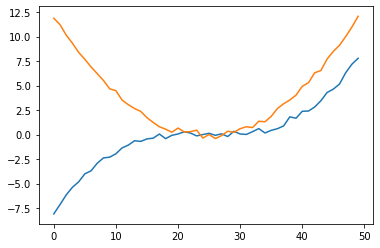

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [8]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        #self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        kernel0 = gpytorch.kernels.RBFKernel()
        kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
List of all kernels: [RBFKernel(
  (raw_lengthscale_constraint): Positive()
), RBFKernel(
  (raw_lengthscale_constraint): Positive()
)]


In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[1.0000e+00, 0.0000e+00, 9.9309e-01,  ..., 0.0000e+00, 5.8693e-08,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.1501e-07, 0.0000e+00,
         5.8693e-08],
        [9.9309e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.1501e-07,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.1501e-07, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9309e-01],
        [5.8693e-08, 0.0000e+00, 1.1501e-07,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.8693e-08, 0.0000e+00,  ..., 9.9309e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.9278e+01,  0.0000e+00],
        [ 1.9278e+01,  0.0000e+00],
        [ 1.4352e+01,  0.0000e+00],
        [ 1.4352e+01,  0.0000e+00],
        [ 4.5299e+00,  0.0000e+00],
        [ 8.8300e+00,  0.0000e+00],
        [ 8.8300e+00,  0.0000e+00],
        [ 1.9613e+00,  0.0000e+00],
        [ 4.5299e+00,  0.0000e+00],
        [ 1.9613e+00,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:648: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[1.0000e+00, 0.0000e+00, 9.9201e-01,  ..., 0.0000e+00, 4.2957e-09,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.3554e-09, 0.0000e+00,
         4.2957e-09],
        [9.9201e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.3554e-09,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.3554e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9201e-01],
        [4.2957e-09, 0.0000e+00, 9.3554e-09,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.2957e-09, 0.0000e+00,  ..., 9.9201e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.8128e+01,  0.0000e+00],
        [ 1.8128e+01,  0.0000e+00],
        [ 1.3958e+01,  0.0000e+00],
        [ 1.3958e+01,  0.0000e+00],
        [ 5.0052e+00,  0.0000e+00],
        [ 9.0689e+00,  0.0000e+00],
        [ 9.0689e+00,  0.0000e+00],
        [ 2.3678e+00,  0.0000e+00],
        [ 5.0052e+00,  0.0000e+00],
        [ 9.7050e-01,

tensor([[1.0000e+00, 0.0000e+00, 9.8936e-01,  ..., 0.0000e+00, 6.9971e-12,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.7943e-10, 0.0000e+00,
         1.9426e-10],
        [9.8936e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.9751e-11,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.7943e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9073e-01],
        [6.9971e-12, 0.0000e+00, 1.9751e-11,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.9426e-10, 0.0000e+00,  ..., 9.9073e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6002e+01,  0.0000e+00],
        [ 1.3038e+01,  0.0000e+00],
        [ 1.7002e+01,  0.0000e+00],
        [ 1.3501e+01,  0.0000e+00],
        [ 9.2886e+00,  0.0000e+00],
        [ 5.8074e+00,  0.0000e+00],
        [ 9.2235e+00,  0.0000e+00],
        [ 3.2024e+00,  0.0000e+00],
        [ 5.4472e+00,  0.0000e+00],
        [ 1.5671e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8654e-01,  ..., 0.0000e+00, 7.4499e-15,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7481e-09, 0.0000e+00,
         7.4795e-10],
        [9.8654e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.7728e-14,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7481e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9129e-01],
        [7.4499e-15, 0.0000e+00, 2.7728e-14,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.4795e-10, 0.0000e+00,  ..., 9.9129e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4401e+01,  0.0000e+00],
        [ 1.2186e+01,  0.0000e+00],
        [ 1.7466e+01,  0.0000e+00],
        [ 6.2881e+00,  0.0000e+00],
        [ 9.2384e+00,  0.0000e+00],
        [ 1.3698e+01,  0.0000e+00],
        [ 3.8542e+00,  0.0000e+00],
        [ 9.1699e+00,  0.0000e+00],
        [ 5.2690e+00,  0.0000e+00],
        [ 2.1354e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8483e-01,  ..., 0.0000e+00, 1.1487e-16,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 7.5346e-09, 0.0000e+00,
         3.4283e-09],
        [9.8483e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.0600e-16,
         0.0000e+00],
        ...,
        [0.0000e+00, 7.5346e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9192e-01],
        [1.1487e-16, 0.0000e+00, 5.0600e-16,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.4283e-09, 0.0000e+00,  ..., 9.9192e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.8038e+01,  0.0000e+00],
        [ 1.3634e+01,  0.0000e+00],
        [ 1.1732e+01,  0.0000e+00],
        [ 1.3924e+01,  0.0000e+00],
        [ 9.1429e+00,  0.0000e+00],
        [ 6.4635e+00,  0.0000e+00],
        [ 9.0842e+00,  0.0000e+00],
        [ 4.1545e+00,  0.0000e+00],
        [ 2.4350e+00,  0.0000e+00],
        [ 5.0415e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8482e-01,  ..., 0.0000e+00, 1.1131e-16,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.8904e-09, 0.0000e+00,
         2.1850e-09],
        [9.8482e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.9095e-16,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.8904e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9173e-01],
        [1.1131e-16, 0.0000e+00, 4.9095e-16,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.1850e-09, 0.0000e+00,  ..., 9.9173e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1729e+01,  0.0000e+00],
        [ 1.3629e+01,  0.0000e+00],
        [ 9.1420e+00,  0.0000e+00],
        [ 1.7863e+01,  0.0000e+00],
        [ 6.4645e+00,  0.0000e+00],
        [ 1.3857e+01,  0.0000e+00],
        [ 9.1127e+00,  0.0000e+00],
        [ 4.1565e+00,  0.0000e+00],
        [ 5.1119e+00,  0.0000e+00],
        [ 2.4371e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8584e-01,  ..., 0.0000e+00, 1.3475e-15,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 7.9474e-10, 0.0000e+00,
         3.2894e-10],
        [9.8584e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.3737e-15,
         0.0000e+00],
        ...,
        [0.0000e+00, 7.9474e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9095e-01],
        [1.3475e-15, 0.0000e+00, 5.3737e-15,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.2894e-10, 0.0000e+00,  ..., 9.9095e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4071e+01,  0.0000e+00],
        [ 1.1994e+01,  0.0000e+00],
        [ 1.7179e+01,  0.0000e+00],
        [ 9.2031e+00,  0.0000e+00],
        [ 1.3578e+01,  0.0000e+00],
        [ 6.3685e+00,  0.0000e+00],
        [ 9.2048e+00,  0.0000e+00],
        [ 3.9850e+00,  0.0000e+00],
        [ 5.3800e+00,  0.0000e+00],
        [ 2.2626e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8702e-01,  ..., 0.0000e+00, 2.3533e-14,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.5698e-10, 0.0000e+00,
         6.0687e-11],
        [9.8702e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 8.3611e-14,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.5698e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9025e-01],
        [2.3533e-14, 0.0000e+00, 8.3611e-14,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 6.0687e-11, 0.0000e+00,  ..., 9.9025e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4636e+01,  0.0000e+00],
        [ 1.2319e+01,  0.0000e+00],
        [ 1.6631e+01,  0.0000e+00],
        [ 1.3335e+01,  0.0000e+00],
        [ 6.2264e+00,  0.0000e+00],
        [ 9.2582e+00,  0.0000e+00],
        [ 9.2559e+00,  0.0000e+00],
        [ 3.7596e+00,  0.0000e+00],
        [ 2.0464e+00,  0.0000e+00],
        [ 5.5852e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8769e-01,  ..., 0.0000e+00, 1.2112e-13,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.4600e-10, 0.0000e+00,
         5.6267e-11],
        [9.8769e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.0276e-13,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.4600e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9022e-01],
        [1.2112e-13, 0.0000e+00, 4.0276e-13,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.6267e-11, 0.0000e+00,  ..., 9.9022e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4993e+01,  0.0000e+00],
        [ 1.2516e+01,  0.0000e+00],
        [ 9.2799e+00,  0.0000e+00],
        [ 6.1267e+00,  0.0000e+00],
        [ 1.6607e+01,  0.0000e+00],
        [ 1.3325e+01,  0.0000e+00],
        [ 9.2576e+00,  0.0000e+00],
        [ 3.6150e+00,  0.0000e+00],
        [ 5.5937e+00,  0.0000e+00],
        [ 1.9150e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8755e-01,  ..., 0.0000e+00, 8.7155e-14,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.1624e-10, 0.0000e+00,
         1.2591e-10],
        [9.8755e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.9370e-13,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.1624e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9055e-01],
        [8.7155e-14, 0.0000e+00, 2.9370e-13,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.2591e-10, 0.0000e+00,  ..., 9.9055e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4919e+01,  0.0000e+00],
        [ 1.2476e+01,  0.0000e+00],
        [ 9.2763e+00,  0.0000e+00],
        [ 1.6861e+01,  0.0000e+00],
        [ 1.3439e+01,  0.0000e+00],
        [ 6.1480e+00,  0.0000e+00],
        [ 9.2370e+00,  0.0000e+00],
        [ 3.6450e+00,  0.0000e+00],
        [ 5.5003e+00,  0.0000e+00],
        [ 1.9418e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8663e-01,  ..., 0.0000e+00, 9.1781e-15,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.6388e-10, 0.0000e+00,
         1.4574e-10],
        [9.8663e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.3873e-14,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.6388e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9061e-01],
        [9.1781e-15, 0.0000e+00, 3.3873e-14,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.4574e-10, 0.0000e+00,  ..., 9.9061e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4443e+01,  0.0000e+00],
        [ 1.2210e+01,  0.0000e+00],
        [ 9.2422e+00,  0.0000e+00],
        [ 1.6908e+01,  0.0000e+00],
        [ 6.2774e+00,  0.0000e+00],
        [ 1.3460e+01,  0.0000e+00],
        [ 3.8374e+00,  0.0000e+00],
        [ 9.2326e+00,  0.0000e+00],
        [ 5.4826e+00,  0.0000e+00],
        [ 2.1195e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8508e-01,  ..., 0.0000e+00, 2.1388e-16,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.2502e-10, 0.0000e+00,
         4.7871e-11],
        [9.8508e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.1882e-16,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.2502e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9015e-01],
        [2.1388e-16, 0.0000e+00, 9.1882e-16,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.7871e-11, 0.0000e+00,  ..., 9.9015e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3740e+01,  0.0000e+00],
        [ 1.1797e+01,  0.0000e+00],
        [ 1.6558e+01,  0.0000e+00],
        [ 9.1590e+00,  0.0000e+00],
        [ 1.3302e+01,  0.0000e+00],
        [ 6.4416e+00,  0.0000e+00],
        [ 9.2612e+00,  0.0000e+00],
        [ 4.1137e+00,  0.0000e+00],
        [ 2.3926e+00,  0.0000e+00],
        [ 5.6117e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8317e-01,  ..., 0.0000e+00, 2.0005e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.0206e-11, 0.0000e+00,
         7.1654e-12],
        [9.8317e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0379e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.0206e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8937e-01],
        [2.0005e-18, 0.0000e+00, 1.0379e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.1654e-12, 0.0000e+00,  ..., 9.8937e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6008e+01,  0.0000e+00],
        [ 1.1332e+01,  0.0000e+00],
        [ 1.2996e+01,  0.0000e+00],
        [ 9.0267e+00,  0.0000e+00],
        [ 1.3041e+01,  0.0000e+00],
        [ 6.5766e+00,  0.0000e+00],
        [ 9.2884e+00,  0.0000e+00],
        [ 4.3905e+00,  0.0000e+00],
        [ 5.8052e+00,  0.0000e+00],
        [ 2.6920e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8124e-01,  ..., 0.0000e+00, 1.7952e-20,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.5549e-12, 0.0000e+00,
         1.1717e-12],
        [9.8124e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.1268e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.5549e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8862e-01],
        [1.7952e-20, 0.0000e+00, 1.1268e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.1717e-12, 0.0000e+00,  ..., 9.8862e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2357e+01,  0.0000e+00],
        [ 1.0912e+01,  0.0000e+00],
        [ 1.5533e+01,  0.0000e+00],
        [ 8.8761e+00,  0.0000e+00],
        [ 6.6568e+00,  0.0000e+00],
        [ 1.2802e+01,  0.0000e+00],
        [ 4.6094e+00,  0.0000e+00],
        [ 9.2941e+00,  0.0000e+00],
        [ 2.9522e+00,  0.0000e+00],
        [ 5.9622e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7969e-01,  ..., 0.0000e+00, 4.0496e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.5589e-12, 0.0000e+00,
         4.9628e-13],
        [9.7969e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.9626e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.5589e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8827e-01],
        [4.0496e-22, 0.0000e+00, 2.9626e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.9628e-13, 0.0000e+00,  ..., 9.8827e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1906e+01,  0.0000e+00],
        [ 1.0605e+01,  0.0000e+00],
        [ 8.7492e+00,  0.0000e+00],
        [ 6.6916e+00,  0.0000e+00],
        [ 1.5321e+01,  0.0000e+00],
        [ 4.7500e+00,  0.0000e+00],
        [ 1.2692e+01,  0.0000e+00],
        [ 9.2912e+00,  0.0000e+00],
        [ 6.0284e+00,  0.0000e+00],
        [ 3.1341e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7884e-01,  ..., 0.0000e+00, 4.9520e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7832e-12, 0.0000e+00,
         5.7090e-13],
        [9.7884e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.9437e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7832e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8833e-01],
        [4.9520e-23, 0.0000e+00, 3.9437e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.7090e-13, 0.0000e+00,  ..., 9.8833e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5355e+01,  0.0000e+00],
        [ 1.1676e+01,  0.0000e+00],
        [ 1.0444e+01,  0.0000e+00],
        [ 1.2710e+01,  0.0000e+00],
        [ 8.6779e+00,  0.0000e+00],
        [ 6.7021e+00,  0.0000e+00],
        [ 9.2919e+00,  0.0000e+00],
        [ 4.8165e+00,  0.0000e+00],
        [ 3.2254e+00,  0.0000e+00],
        [ 6.0179e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7876e-01,  ..., 0.0000e+00, 4.1158e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.2972e-12, 0.0000e+00,
         7.4334e-13],
        [9.7876e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.3023e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.2972e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8844e-01],
        [4.1158e-23, 0.0000e+00, 3.3023e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.4334e-13, 0.0000e+00,  ..., 9.8844e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5420e+01,  0.0000e+00],
        [ 1.1657e+01,  0.0000e+00],
        [ 1.0431e+01,  0.0000e+00],
        [ 1.2743e+01,  0.0000e+00],
        [ 8.6716e+00,  0.0000e+00],
        [ 6.7027e+00,  0.0000e+00],
        [ 9.2930e+00,  0.0000e+00],
        [ 4.8220e+00,  0.0000e+00],
        [ 3.2331e+00,  0.0000e+00],
        [ 5.9979e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7922e-01,  ..., 0.0000e+00, 1.2564e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7390e-12, 0.0000e+00,
         5.5616e-13],
        [9.7922e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.6368e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7390e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8832e-01],
        [1.2564e-22, 0.0000e+00, 9.6368e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.5616e-13, 0.0000e+00,  ..., 9.8832e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1776e+01,  0.0000e+00],
        [ 1.0515e+01,  0.0000e+00],
        [ 8.7095e+00,  0.0000e+00],
        [ 1.5349e+01,  0.0000e+00],
        [ 6.6981e+00,  0.0000e+00],
        [ 4.7880e+00,  0.0000e+00],
        [ 1.2706e+01,  0.0000e+00],
        [ 9.2918e+00,  0.0000e+00],
        [ 3.1857e+00,  0.0000e+00],
        [ 6.0199e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7980e-01,  ..., 0.0000e+00, 5.2050e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.0068e-12, 0.0000e+00,
         3.1466e-13],
        [9.7980e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.7694e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.0068e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8808e-01],
        [5.2050e-22, 0.0000e+00, 3.7694e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.1466e-13, 0.0000e+00,  ..., 9.8808e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1934e+01,  0.0000e+00],
        [ 1.0624e+01,  0.0000e+00],
        [ 8.7576e+00,  0.0000e+00],
        [ 1.5213e+01,  0.0000e+00],
        [ 6.6900e+00,  0.0000e+00],
        [ 4.7415e+00,  0.0000e+00],
        [ 1.2634e+01,  0.0000e+00],
        [ 9.2884e+00,  0.0000e+00],
        [ 6.0615e+00,  0.0000e+00],
        [ 3.1228e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8023e-01,  ..., 0.0000e+00, 1.5129e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.6931e-13, 0.0000e+00,
         3.0247e-13],
        [9.8023e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0494e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.6931e-13, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8807e-01],
        [1.5129e-21, 0.0000e+00, 1.0494e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.0247e-13, 0.0000e+00,  ..., 9.8807e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5203e+01,  0.0000e+00],
        [ 1.2057e+01,  0.0000e+00],
        [ 1.0709e+01,  0.0000e+00],
        [ 6.6820e+00,  0.0000e+00],
        [ 8.7936e+00,  0.0000e+00],
        [ 1.2629e+01,  0.0000e+00],
        [ 4.7043e+00,  0.0000e+00],
        [ 3.0735e+00,  0.0000e+00],
        [ 9.2881e+00,  0.0000e+00],
        [ 6.0643e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8048e-01,  ..., 0.0000e+00, 2.7974e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.9150e-12, 0.0000e+00,
         6.1496e-13],
        [9.8048e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.8928e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.9150e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8836e-01],
        [2.7974e-21, 0.0000e+00, 1.8928e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 6.1496e-13, 0.0000e+00,  ..., 9.8836e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2129e+01,  0.0000e+00],
        [ 1.0758e+01,  0.0000e+00],
        [ 8.8143e+00,  0.0000e+00],
        [ 1.5373e+01,  0.0000e+00],
        [ 6.6766e+00,  0.0000e+00],
        [ 4.6818e+00,  0.0000e+00],
        [ 1.2719e+01,  0.0000e+00],
        [ 9.2923e+00,  0.0000e+00],
        [ 3.0443e+00,  0.0000e+00],
        [ 6.0123e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8067e-01,  ..., 0.0000e+00, 4.3844e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.3256e-12, 0.0000e+00,
         1.4375e-12],
        [9.8067e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.9132e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.3256e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8871e-01],
        [4.3844e-21, 0.0000e+00, 2.9132e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.4375e-12, 0.0000e+00,  ..., 9.8871e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2183e+01,  0.0000e+00],
        [ 1.0795e+01,  0.0000e+00],
        [ 8.8293e+00,  0.0000e+00],
        [ 1.5584e+01,  0.0000e+00],
        [ 6.6724e+00,  0.0000e+00],
        [ 4.6650e+00,  0.0000e+00],
        [ 1.2828e+01,  0.0000e+00],
        [ 9.2943e+00,  0.0000e+00],
        [ 5.9457e+00,  0.0000e+00],
        [ 3.0225e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8094e-01,  ..., 0.0000e+00, 8.6065e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 6.7354e-12, 0.0000e+00,
         2.2805e-12],
        [9.8094e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.5649e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 6.7354e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8890e-01],
        [8.6065e-21, 0.0000e+00, 5.5649e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.2805e-12, 0.0000e+00,  ..., 9.8890e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2265e+01,  0.0000e+00],
        [ 1.0851e+01,  0.0000e+00],
        [ 8.8518e+00,  0.0000e+00],
        [ 1.5702e+01,  0.0000e+00],
        [ 6.6653e+00,  0.0000e+00],
        [ 4.6389e+00,  0.0000e+00],
        [ 1.2889e+01,  0.0000e+00],
        [ 9.2940e+00,  0.0000e+00],
        [ 5.9073e+00,  0.0000e+00],
        [ 2.9893e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8141e-01,  ..., 0.0000e+00, 2.6779e-20,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 7.7326e-12, 0.0000e+00,
         2.6334e-12],
        [9.8141e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.6539e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 7.7326e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8896e-01],
        [2.6779e-20, 0.0000e+00, 1.6539e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.6334e-12, 0.0000e+00,  ..., 9.8896e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2407e+01,  0.0000e+00],
        [ 1.0946e+01,  0.0000e+00],
        [ 1.5740e+01,  0.0000e+00],
        [ 8.8893e+00,  0.0000e+00],
        [ 6.6517e+00,  0.0000e+00],
        [ 1.2907e+01,  0.0000e+00],
        [ 4.5928e+00,  0.0000e+00],
        [ 9.2937e+00,  0.0000e+00],
        [ 2.9317e+00,  0.0000e+00],
        [ 5.8951e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8203e-01,  ..., 0.0000e+00, 1.2452e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.4616e-12, 0.0000e+00,
         3.2497e-12],
        [9.8203e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 7.2275e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.4616e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8904e-01],
        [1.2452e-19, 0.0000e+00, 7.2275e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.2497e-12, 0.0000e+00,  ..., 9.8904e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2608e+01,  0.0000e+00],
        [ 1.1080e+01,  0.0000e+00],
        [ 1.5795e+01,  0.0000e+00],
        [ 8.9394e+00,  0.0000e+00],
        [ 6.6294e+00,  0.0000e+00],
        [ 1.2935e+01,  0.0000e+00],
        [ 4.5259e+00,  0.0000e+00],
        [ 9.2930e+00,  0.0000e+00],
        [ 2.8501e+00,  0.0000e+00],
        [ 5.8768e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8270e-01,  ..., 0.0000e+00, 6.3463e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.4674e-11, 0.0000e+00,
         5.1340e-12],
        [9.8270e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.4490e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.4674e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8923e-01],
        [6.3463e-19, 0.0000e+00, 3.4490e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.1340e-12, 0.0000e+00,  ..., 9.8923e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2831e+01,  0.0000e+00],
        [ 1.1226e+01,  0.0000e+00],
        [ 1.5917e+01,  0.0000e+00],
        [ 1.2996e+01,  0.0000e+00],
        [ 8.9912e+00,  0.0000e+00],
        [ 6.6006e+00,  0.0000e+00],
        [ 4.4489e+00,  0.0000e+00],
        [ 9.2908e+00,  0.0000e+00],
        [ 2.7591e+00,  0.0000e+00],
        [ 5.8360e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8324e-01,  ..., 0.0000e+00, 2.4047e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.3750e-11, 0.0000e+00,
         8.4794e-12],
        [9.8324e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.2384e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.3750e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8944e-01],
        [2.4047e-18, 0.0000e+00, 1.2384e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 8.4794e-12, 0.0000e+00,  ..., 9.8944e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6055e+01,  0.0000e+00],
        [ 1.1350e+01,  0.0000e+00],
        [ 1.3023e+01,  0.0000e+00],
        [ 9.0324e+00,  0.0000e+00],
        [ 6.5724e+00,  0.0000e+00],
        [ 1.3064e+01,  0.0000e+00],
        [ 9.2869e+00,  0.0000e+00],
        [ 4.3808e+00,  0.0000e+00],
        [ 5.7893e+00,  0.0000e+00],
        [ 2.6811e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8356e-01,  ..., 0.0000e+00, 5.1273e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.0267e-11, 0.0000e+00,
         1.0917e-11],
        [9.8356e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.5610e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.0267e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8954e-01],
        [5.1273e-18, 0.0000e+00, 2.5610e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0917e-11, 0.0000e+00,  ..., 9.8954e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3136e+01,  0.0000e+00],
        [ 1.1422e+01,  0.0000e+00],
        [ 1.6125e+01,  0.0000e+00],
        [ 9.0551e+00,  0.0000e+00],
        [ 6.5545e+00,  0.0000e+00],
        [ 1.3098e+01,  0.0000e+00],
        [ 9.2844e+00,  0.0000e+00],
        [ 4.3400e+00,  0.0000e+00],
        [ 5.7650e+00,  0.0000e+00],
        [ 2.6352e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8360e-01,  ..., 0.0000e+00, 5.7931e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.8958e-11, 0.0000e+00,
         1.0426e-11],
        [9.8360e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.8793e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.8958e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8952e-01],
        [5.7931e-18, 0.0000e+00, 2.8793e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0426e-11, 0.0000e+00,  ..., 9.8952e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3155e+01,  0.0000e+00],
        [ 1.1434e+01,  0.0000e+00],
        [ 1.6112e+01,  0.0000e+00],
        [ 9.0588e+00,  0.0000e+00],
        [ 6.5514e+00,  0.0000e+00],
        [ 1.3092e+01,  0.0000e+00],
        [ 9.2849e+00,  0.0000e+00],
        [ 4.3332e+00,  0.0000e+00],
        [ 5.7695e+00,  0.0000e+00],
        [ 2.6277e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8346e-01,  ..., 0.0000e+00, 4.0578e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.5536e-11, 0.0000e+00,
         9.1451e-12],
        [9.8346e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.0460e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.5536e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8947e-01],
        [4.0578e-18, 0.0000e+00, 2.0460e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.1451e-12, 0.0000e+00,  ..., 9.8947e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3101e+01,  0.0000e+00],
        [ 1.1400e+01,  0.0000e+00],
        [ 9.0482e+00,  0.0000e+00],
        [ 1.6076e+01,  0.0000e+00],
        [ 6.5602e+00,  0.0000e+00],
        [ 1.3074e+01,  0.0000e+00],
        [ 9.2862e+00,  0.0000e+00],
        [ 4.3528e+00,  0.0000e+00],
        [ 5.7821e+00,  0.0000e+00],
        [ 2.6495e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8323e-01,  ..., 0.0000e+00, 2.3425e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.5338e-11, 0.0000e+00,
         9.0714e-12],
        [9.8323e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.2077e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.5338e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8947e-01],
        [2.3425e-18, 0.0000e+00, 1.2077e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.0714e-12, 0.0000e+00,  ..., 9.8947e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6074e+01,  0.0000e+00],
        [ 1.1347e+01,  0.0000e+00],
        [ 1.3020e+01,  0.0000e+00],
        [ 9.0316e+00,  0.0000e+00],
        [ 1.3073e+01,  0.0000e+00],
        [ 6.5730e+00,  0.0000e+00],
        [ 9.2863e+00,  0.0000e+00],
        [ 4.3822e+00,  0.0000e+00],
        [ 5.7829e+00,  0.0000e+00],
        [ 2.6826e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8304e-01,  ..., 0.0000e+00, 1.4677e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.7329e-11, 0.0000e+00,
         9.8152e-12],
        [9.8304e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 7.7109e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.7329e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8950e-01],
        [1.4677e-18, 0.0000e+00, 7.7109e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.8152e-12, 0.0000e+00,  ..., 9.8950e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1303e+01,  0.0000e+00],
        [ 1.2951e+01,  0.0000e+00],
        [ 9.0173e+00,  0.0000e+00],
        [ 6.5834e+00,  0.0000e+00],
        [ 1.6096e+01,  0.0000e+00],
        [ 1.3083e+01,  0.0000e+00],
        [ 4.4066e+00,  0.0000e+00],
        [ 9.2855e+00,  0.0000e+00],
        [ 5.7753e+00,  0.0000e+00],
        [ 2.7104e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8294e-01,  ..., 0.0000e+00, 1.1468e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.6592e-11, 0.0000e+00,
         9.5394e-12],
        [9.8294e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 6.0855e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.6592e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8949e-01],
        [1.1468e-18, 0.0000e+00, 6.0855e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.5394e-12, 0.0000e+00,  ..., 9.8949e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1280e+01,  0.0000e+00],
        [ 1.2916e+01,  0.0000e+00],
        [ 9.0097e+00,  0.0000e+00],
        [ 1.6088e+01,  0.0000e+00],
        [ 6.5886e+00,  0.0000e+00],
        [ 1.3079e+01,  0.0000e+00],
        [ 9.2858e+00,  0.0000e+00],
        [ 4.4192e+00,  0.0000e+00],
        [ 5.7781e+00,  0.0000e+00],
        [ 2.7248e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8292e-01,  ..., 0.0000e+00, 1.0731e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.1545e-11, 0.0000e+00,
         7.6610e-12],
        [9.8292e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.7097e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.1545e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8940e-01],
        [1.0731e-18, 0.0000e+00, 5.7097e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.6610e-12, 0.0000e+00,  ..., 9.8940e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1274e+01,  0.0000e+00],
        [ 1.2906e+01,  0.0000e+00],
        [ 9.0076e+00,  0.0000e+00],
        [ 1.6027e+01,  0.0000e+00],
        [ 6.5900e+00,  0.0000e+00],
        [ 1.3050e+01,  0.0000e+00],
        [ 4.4226e+00,  0.0000e+00],
        [ 9.2878e+00,  0.0000e+00],
        [ 5.7989e+00,  0.0000e+00],
        [ 2.7287e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8290e-01,  ..., 0.0000e+00, 1.0281e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.6456e-11, 0.0000e+00,
         5.7853e-12],
        [9.8290e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.4798e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.6456e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8928e-01],
        [1.0281e-18, 0.0000e+00, 5.4798e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.7853e-12, 0.0000e+00,  ..., 9.8928e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1270e+01,  0.0000e+00],
        [ 1.2900e+01,  0.0000e+00],
        [ 1.5950e+01,  0.0000e+00],
        [ 9.0063e+00,  0.0000e+00],
        [ 6.5909e+00,  0.0000e+00],
        [ 1.3012e+01,  0.0000e+00],
        [ 9.2900e+00,  0.0000e+00],
        [ 4.4248e+00,  0.0000e+00],
        [ 5.8251e+00,  0.0000e+00],
        [ 2.7312e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8282e-01,  ..., 0.0000e+00, 8.6249e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.4033e-11, 0.0000e+00,
         4.9006e-12],
        [9.8282e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.6296e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.4033e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8921e-01],
        [8.6249e-19, 0.0000e+00, 4.6296e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.9006e-12, 0.0000e+00,  ..., 9.8921e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1254e+01,  0.0000e+00],
        [ 1.2875e+01,  0.0000e+00],
        [ 1.5905e+01,  0.0000e+00],
        [ 9.0008e+00,  0.0000e+00],
        [ 6.5945e+00,  0.0000e+00],
        [ 1.2990e+01,  0.0000e+00],
        [ 9.2911e+00,  0.0000e+00],
        [ 4.4336e+00,  0.0000e+00],
        [ 5.8402e+00,  0.0000e+00],
        [ 2.7414e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8267e-01,  ..., 0.0000e+00, 5.9653e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.3531e-11, 0.0000e+00,
         4.7181e-12],
        [9.8267e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.2501e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.3531e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8920e-01],
        [5.9653e-19, 0.0000e+00, 3.2501e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.7181e-12, 0.0000e+00,  ..., 9.8920e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1220e+01,  0.0000e+00],
        [ 1.2823e+01,  0.0000e+00],
        [ 8.9893e+00,  0.0000e+00],
        [ 1.5895e+01,  0.0000e+00],
        [ 6.6018e+00,  0.0000e+00],
        [ 4.4519e+00,  0.0000e+00],
        [ 1.2985e+01,  0.0000e+00],
        [ 9.2913e+00,  0.0000e+00],
        [ 5.8437e+00,  0.0000e+00],
        [ 2.7627e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8247e-01,  ..., 0.0000e+00, 3.6409e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.3016e-11, 0.0000e+00,
         4.5310e-12],
        [9.8247e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.0237e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.3016e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8918e-01],
        [3.6409e-19, 0.0000e+00, 2.0237e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.5310e-12, 0.0000e+00,  ..., 9.8918e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1175e+01,  0.0000e+00],
        [ 1.2754e+01,  0.0000e+00],
        [ 8.9737e+00,  0.0000e+00],
        [ 1.5884e+01,  0.0000e+00],
        [ 6.6111e+00,  0.0000e+00],
        [ 1.2979e+01,  0.0000e+00],
        [ 4.4759e+00,  0.0000e+00],
        [ 9.2915e+00,  0.0000e+00],
        [ 5.8473e+00,  0.0000e+00],
        [ 2.7907e+00,

In [28]:
likelihood
#torch.autograd.functional.hessian(likelihood, train_x)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [20]:
for parameter in model.named_parameters():
    print(parameter)

AttributeError: 'Parameter' object has no attribute 'hessian'

In [ ]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [ ]:
print(likelihood.noise)
print(likelihood.task_noises)

In [ ]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

In [ ]:
for parameter in model.named_parameters():
    print(parameter)

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


In [ ]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [ ]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

# Test Diffable SE Kernel

In [ ]:
X = torch.tensor([int(1), int(2), int(3)])
X

In [ ]:
X = torch.linspace(float(-2), float(2), int(1))

In [ ]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

In [ ]:
print(SE)
print(SE.diff(x2))
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

In [ ]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [31]:
a, b, c, d, x, y, dx1 = var('a, b, c, d, x, y, dx1')
poly = (a*(2*(c+b)+a)+a)*y
#poly = a*b*dx1**3
print(type(poly))
#poly = 839840583*x^75
print(poly.degree(dx1))
print(poly.operands())
print([op.is_numeric() for op in poly.operands()])

<class 'sage.symbolic.expression.Expression'>
0
[(a + 2*b + 2*c)*a + a, y]
[False, False]


In [39]:
return_list = []
l1 = [[42, 17], [128, 256]]
for i, l in enumerate(l1):
    if i == 0:
        func1 = lambda : l[0]*l[1]
        return_list.append(func1)
    else: 
        func2 = lambda : l[0]*l[1]
        return_list.append(func2)

for func in return_list:
    print(func())

32768
32768


1764
